In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import MinMaxScaler
import string
from nltk.corpus import stopwords
from tensorflow.keras.regularizers import l2

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')



# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Define directories for each dataset
directories = {
    'agoda_hotel_reviews': (1, 10),  
    'tripadvisor_hotel_reviews': (1, 5),
    'klook_hotel_reviews': (1, 5),  
    'booking_hotel_reviews': (1, 10)
}

In [2]:
# Function to load and normalize data
def load_and_normalize_data():
    all_reviews = []
    for directory, (min_score, max_score) in directories.items():           
        path = os.path.join('raw data', directory)
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, filename))
                scaler = MinMaxScaler(feature_range=(0, 1))
                df['normalized_score'] = scaler.fit_transform(df[['Review Score']])
                all_reviews.append(df)
    return pd.concat(all_reviews, ignore_index=True)

# Load and normalize data
df = load_and_normalize_data()

In [3]:
# Function to lemmatize text
def preprocess_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()

    # Step 2: Remove punctuation
    # You can translate punctuation to None (removing it)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 3: Tokenization
    tokens = nltk.word_tokenize(text)

    # Step 4: Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Step 5: Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return the processed text as a single string
    return ' '.join(lemmatized_tokens)

# Lemmatize the review content
df['cleaned_content'] = df['Review Content'].apply(preprocess_text)
# Convert normalized scores to binary labels (1 for positive, 0 for negative)
df['label'] = df['normalized_score'].apply(lambda x: 0 if x <= 0.25 else (2 if x >= 0.75 else 1))
print(df[['normalized_score', 'label']].describe())

       normalized_score         label
count      10242.000000  10242.000000
mean           0.855256      1.781976
std            0.221119      0.497445
min            0.000000      0.000000
25%            0.777778      2.000000
50%            1.000000      2.000000
75%            1.000000      2.000000
max            1.000000      2.000000


In [4]:
def count_labels(df):
    # Count the occurrences of each label
    positive_count = (df['label'] == 2).sum()
    negative_count = (df['label'] == 0).sum()
    neutral_count = (df['label'] == 1).sum()

    # Print the counts
    print(f'Positive reviews: {positive_count}')
    print(f'Negative reviews: {negative_count}')
    print(f'Neutral reviews: {neutral_count}')
    print(f"Total: {df['label'].count()}")
count_labels(df)

Positive reviews: 8403
Negative reviews: 394
Neutral reviews: 1445
Total: 10242


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


def prepare_data(df, text_column, label_column, num_words=5000, maxlen=100, test_size=0.3, random_state=42):
    """
    Prepares the data for training by tokenizing the text and splitting the data into train and test sets.
    
    Parameters:
    - df (DataFrame): The input DataFrame containing the text and labels.
    - text_column (str): The name of the column containing the cleaned text.    
    - label_column (str): The name of the column containing the labels.
    - num_words (int): The maximum number of words to keep, based on word frequency.
    - maxlen (int): The maximum length of sequences.
    - test_size (float): The proportion of the dataset to include in the test split.
    - random_state (int): Controls the shuffling applied to the data before applying the split.
    
    Returns:
    - X_train (array): Padded sequences for the training data.
    - X_test (array): Padded sequences for the testing data.
    - y_train (Series): Labels for the training data.
    - y_test (Series): Labels for the testing data.
    - tokenizer (Tokenizer): The tokenizer fitted on the text data.
    """
    
    # Tokenization
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(df[text_column])

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(df[text_column])
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    # Prepare labels
    labels = df[label_column]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, labels, test_size=test_size, stratify=labels, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test, tokenizer

# Assuming 'df' is your DataFrame with columns 'cleaned_content' and 'label'
X_train, X_test, y_train, y_test, tokenizer = prepare_data(df, text_column='cleaned_content', label_column='label')

In [11]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
def kfold_validation(df, text_column, label_column, num_words=5000, maxlen=100, k=5, epochs=20, learning_rate=1e-4):
    # Prepare data
    X = df[text_column].values
    y = df[label_column].values

    # Tokenization
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(X)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    # K-Fold Cross-Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracy_results = []
    val_accuracy_results = []

    for fold, (train_index, val_index) in enumerate(kf.split(padded_sequences)):
        print(f"Training Fold {fold + 1}/{k}")
        
        # Split data into training and validation sets
        X_train, X_val = padded_sequences[train_index], padded_sequences[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create and compile the model
        model = Sequential([
            Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
            Conv1D(filters=64, kernel_size=5, activation='relu'),
            MaxPooling1D(pool_size=2),
            Bidirectional(LSTM(64, return_sequences=True)),
            Bidirectional(LSTM(64)),
            Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(0.5),
            Dense(3, activation='softmax')  # Assuming 3 classes for multi-class classification
        ])
        
        model.compile(optimizer=Adam(learning_rate=learning_rate), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=2)

        # Store accuracy results for each fold
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        accuracy_results.append(accuracy)
        val_accuracy_results.append(val_accuracy)

    return accuracy_results, val_accuracy_results, tokenizer

# Example usage
# Assuming 'df' is your DataFrame with columns 'cleaned_content' and 'label'
accuracy_results, val_accuracy_results, tokenizer = kfold_validation(df, text_column='cleaned_content', label_column='label')

Training Fold 1/5
Epoch 1/20


c:\Users\Predator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


257/257 - 28s - 108ms/step - accuracy: 0.8158 - loss: 0.7179 - val_accuracy: 0.8145 - val_loss: 0.6268
Epoch 2/20
257/257 - 12s - 48ms/step - accuracy: 0.8223 - loss: 0.6232 - val_accuracy: 0.8165 - val_loss: 0.5765
Epoch 3/20
257/257 - 12s - 48ms/step - accuracy: 0.8424 - loss: 0.4945 - val_accuracy: 0.8389 - val_loss: 0.4694
Epoch 4/20
257/257 - 13s - 49ms/step - accuracy: 0.8673 - loss: 0.4163 - val_accuracy: 0.8370 - val_loss: 0.4694
Epoch 5/20
257/257 - 13s - 49ms/step - accuracy: 0.8782 - loss: 0.3801 - val_accuracy: 0.8336 - val_loss: 0.4722
Epoch 6/20
257/257 - 13s - 49ms/step - accuracy: 0.8921 - loss: 0.3494 - val_accuracy: 0.8414 - val_loss: 0.4798
Epoch 7/20
257/257 - 13s - 49ms/step - accuracy: 0.9003 - loss: 0.3149 - val_accuracy: 0.8404 - val_loss: 0.5239
Epoch 8/20
257/257 - 13s - 50ms/step - accuracy: 0.9109 - loss: 0.2901 - val_accuracy: 0.8321 - val_loss: 0.5469
Epoch 9/20
257/257 - 13s - 49ms/step - accuracy: 0.9199 - loss: 0.2682 - val_accuracy: 0.8346 - val_loss: 

Average Training Accuracy: 0.9224
Average Validation Accuracy: 0.8293


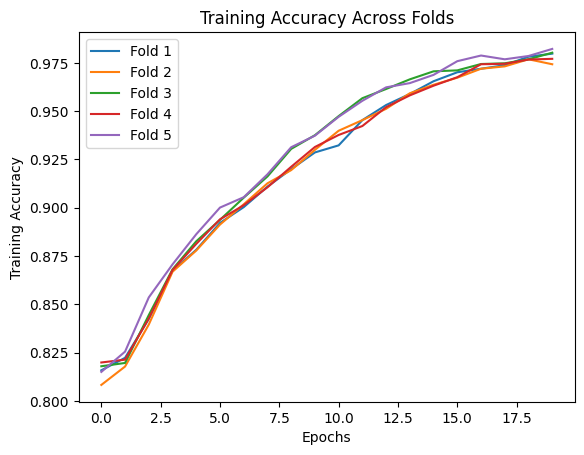

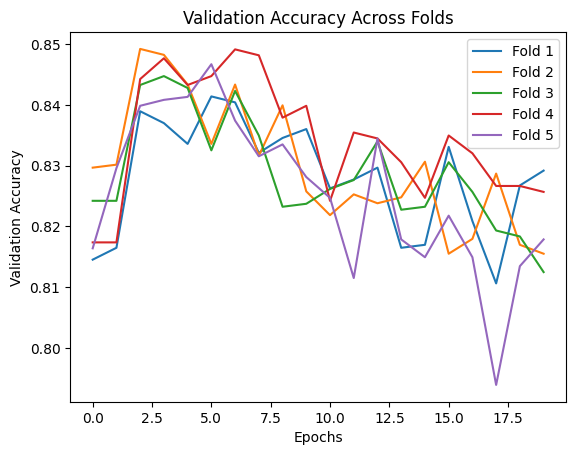

In [15]:
import numpy as np

# Assuming accuracy_results and val_accuracy_results are lists of results from K-Fold
average_accuracy = np.mean([np.mean(acc) for acc in accuracy_results])
average_val_accuracy = np.mean([np.mean(val_acc) for val_acc in val_accuracy_results])

print(f'Average Training Accuracy: {average_accuracy:.4f}')
print(f'Average Validation Accuracy: {average_val_accuracy:.4f}')
import matplotlib.pyplot as plt

for fold in range(len(accuracy_results)):
    plt.plot(accuracy_results[fold], label=f'Fold {fold + 1}')

plt.title('Training Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

for fold in range(len(val_accuracy_results)):
    plt.plot(val_accuracy_results[fold], label=f'Fold {fold + 1}')

plt.title('Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()




Epoch 1/20


c:\Users\Predator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


180/180 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - accuracy: 0.7594 - loss: 0.8918 - val_accuracy: 0.8180 - val_loss: 0.6220
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8240 - loss: 0.6460 - val_accuracy: 0.8180 - val_loss: 0.5951
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8153 - loss: 0.6064 - val_accuracy: 0.8354 - val_loss: 0.4810
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8583 - loss: 0.4565 - val_accuracy: 0.8424 - val_loss: 0.4698
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8830 - loss: 0.3965 - val_accuracy: 0.8459 - val_loss: 0.4710
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8889 - loss: 0.3698 - val_accuracy: 0.8508 - val_loss: 0.4920
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8988 - loss: 0.3315 - val_accuracy: 0.8501 - val_loss: 0.5272
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9077 - loss: 0.2914 - val_accurac

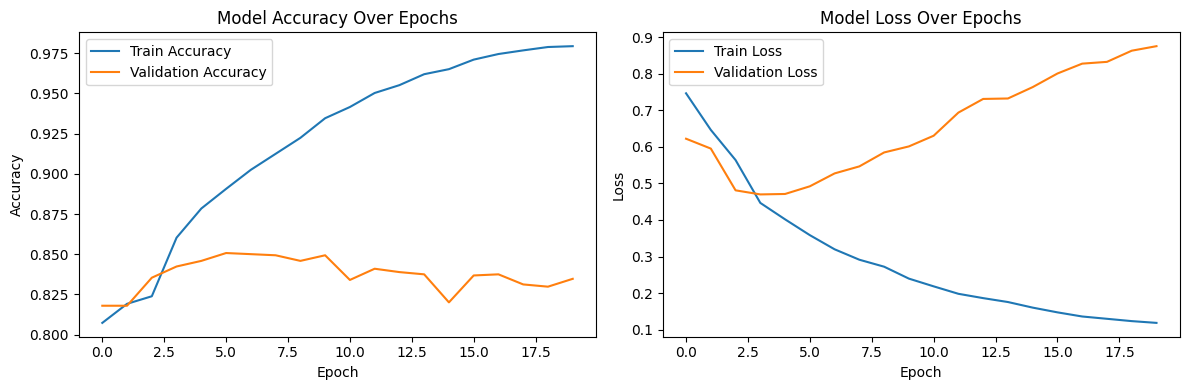

In [16]:
# Model creation
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Corrected placement
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes for multi-class classification
])

# Model Compilation
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')  # Rounded to 4 decimal places for clarity

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()